# Bijectors

We visualize some bijectors.

In [1]:
from zenflow.utils import (
    rational_quadratic_spline_forward,
    rational_quadratic_spline_inverse,
    normalize_spline_params,
    squareplus,
)
import matplotlib.pyplot as plt
import numpy as np
from jax.nn import softplus

This compares the squareplus activation with softplus activation.

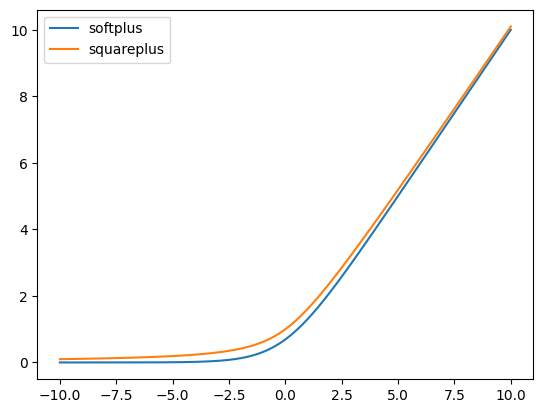

In [2]:
x = np.linspace(-10, 10, 1000)

plt.plot(x, softplus(x), label="softplus")
plt.plot(x, squareplus(x), label="squareplus")
plt.legend();

This is a check that spine transform works properly, also outside the [0, 1] interval.

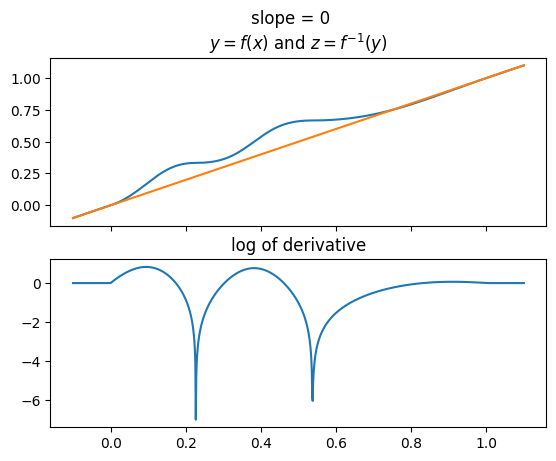

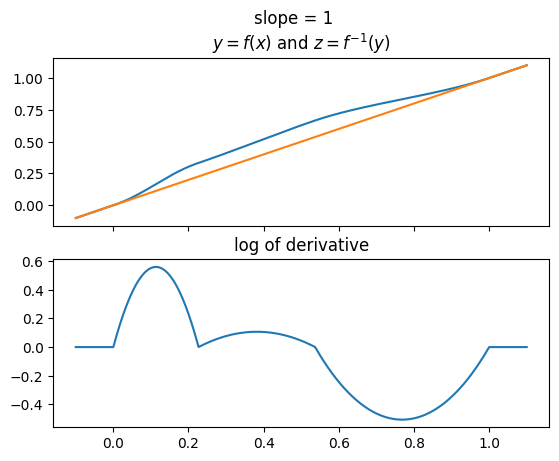

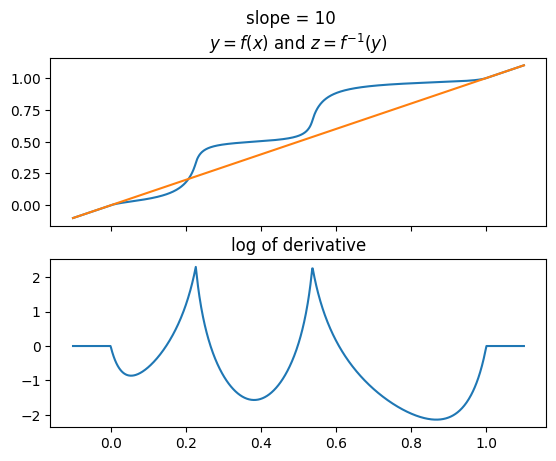

In [3]:
x = np.linspace(-0.1, 1.1, 1000).reshape(1000, 1)

knots = 3
dx, dy, slope = normalize_spline_params(
    np.arange(knots) - 3, np.zeros(knots), np.zeros(knots - 1)
)

nx = np.prod(x.shape)
dx = np.tile(dx, nx).reshape(*x.shape, -1)
dy = np.tile(dy, nx).reshape(*x.shape, -1)
slope = np.tile(slope, nx).reshape(*x.shape, -1)

for sl in (0, 1, 10):
    slope1 = sl * slope
    fig, ax = plt.subplots(2, 1, sharex=True)
    y, log_det = rational_quadratic_spline_forward(x, dx, dy, slope1)
    x2 = rational_quadratic_spline_inverse(y, dx, dy, slope1)
    plt.suptitle(f"slope = {sl}")
    ax[0].set_title("$y = f(x)$ and $z = f^{-1}(y)$")
    ax[0].plot(x.reshape(-1), y.reshape(-1))
    ax[0].plot(x.reshape(-1), x2.reshape(-1))
    ax[1].plot(x.reshape(-1), log_det)
    ax[1].set_title("log of derivative")


We check that the spline transform is approximately the identity if spline parameters are normally distributed around zero with small variance.

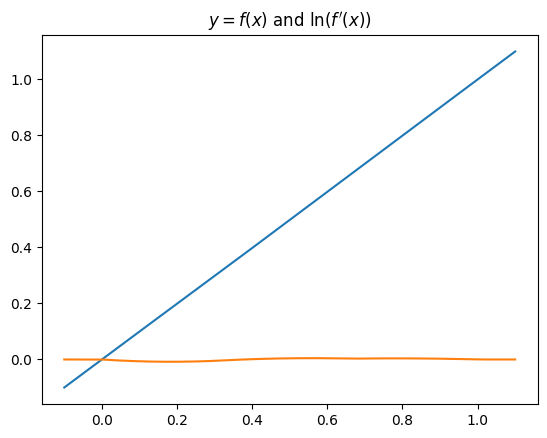

In [4]:
rng = np.random.default_rng(1)

x = np.linspace(-0.1, 1.1, 1000).reshape(1000, 1)

scale = 0.01
knots = 3
dx, dy, slope = normalize_spline_params(
    scale * rng.normal(size=knots),
    scale * rng.normal(size=knots),
    scale * rng.normal(size=knots - 1),
)

nx = np.prod(x.shape)
dx = np.tile(dx, nx).reshape(*x.shape, -1)
dy = np.tile(dy, nx).reshape(*x.shape, -1)
slope = np.tile(slope, nx).reshape(*x.shape, -1)

y, log_det = rational_quadratic_spline_forward(x, dx, dy, slope)
plt.plot(x.reshape(-1), y.reshape(-1))
plt.plot(x.reshape(-1), log_det)
plt.title("$y = f(x)$ and $\\ln(f'(x))$");

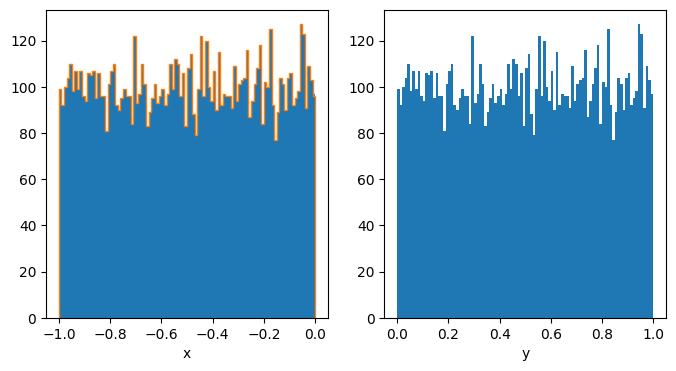

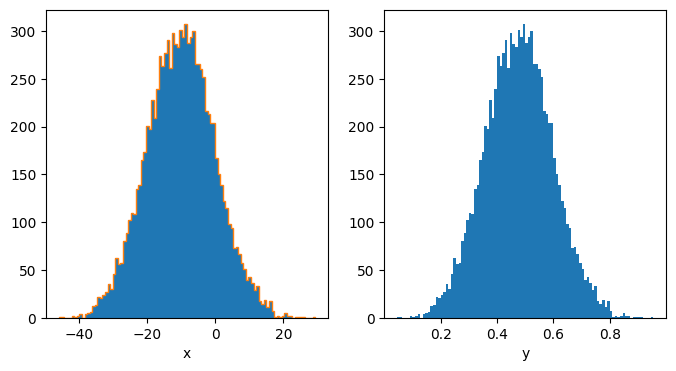

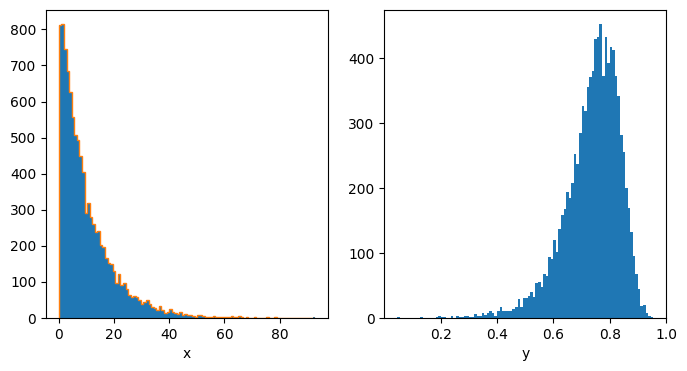

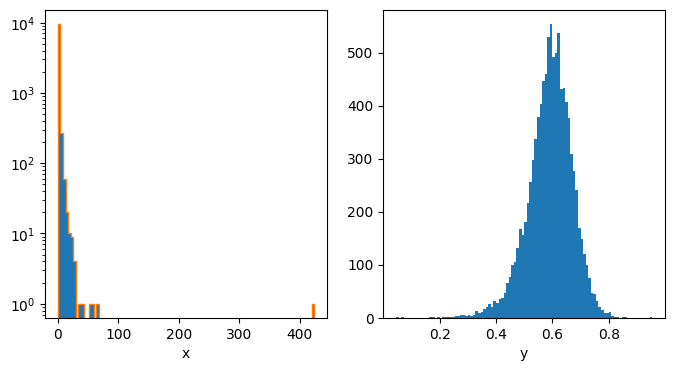

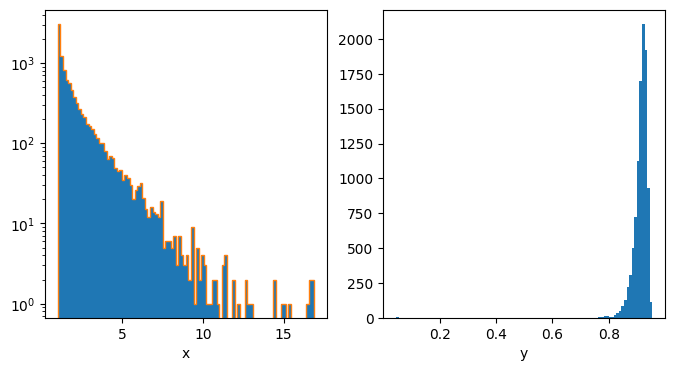

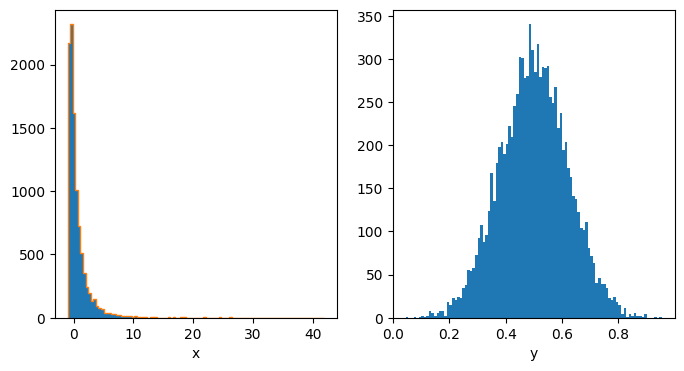

In [8]:
from zenflow.bijectors import ShiftBounds
import jax
import jax.numpy as jnp


def draw(x, y, x2, i, log=False):
    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    xe = ax[0].hist(x[:,i], bins=100)[1]
    n = np.histogram(x2[:,i], bins=xe)[0]
    ax[0].stairs(n, xe, fill=False)
    ax[0].set_xlabel("x")

    if log:
        ax[0].set_yscale("log")
    ax[1].hist(y[:,i], bins=100)
    ax[1].set_xlabel("y")


rng = np.random.default_rng(1)

x = np.column_stack([
    rng.uniform(size=(10000, 1)) - 1,
    rng.normal(-10, 10, size=(10000, 1)),
    rng.exponential(10, size=(10000, 1)),
    rng.pareto(2, size=(10000, 1)),
    1 + rng.normal(size=(10000, 1)) ** 2,
    -1 + rng.lognormal(size=(10000, 1))
])
x = jax.device_put(x)

bounds = [
    (0, -1, 0),
    (1, -np.inf, np.inf),
    (2, 0, np.inf),
    (3, 0, np.inf),
    (4, 1, np.inf),
    (5, -1, np.inf),
]

tr = ShiftBounds(bounds=bounds)
variables = tr.init(jax.random.PRNGKey(1), x, None)
(y, log_det), variables = tr.apply(
    variables, x, None, mutable="batch_stats", train=True
)
x2 = tr.apply(variables, y, None, method="inverse")

draw(x, y, x2, 0)
draw(x, y, x2, 1)
draw(x, y, x2, 2)
draw(x, y, x2, 3, log=True)
draw(x, y, x2, 4, log=True)
draw(x, y, x2, 5)